In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'font.size': 32})
plt.rcParams["figure.figsize"] = (12,8)
import torch
import numpy as np
import scipy.signal
import scipy.io
import pandas as pd
import itertools
from itertools import product
import os


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE 
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import RidgeClassifierCV, LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_curve, roc_auc_score, mean_squared_error as MSE, log_loss,r2_score
import seaborn as sns
import xgboost as xgb

## DATASET

In [35]:
storage_patrh = os.path.join(os.getcwd(),'feature_storage')
listfiles = os.listdir(storage_patrh)
list_featurestorage = [fname for fname in listfiles if fname.endswith(('csv','json')) ]
list_featurestorage

['102.csv',
 '103.csv',
 'EWT_features_test.json',
 'EWT_features_test_x.json',
 'EWT_features_train.json',
 'EWT_features_train_x.json',
 'kernels (1).json',
 'minirocket2000_Best_test.csv',
 'minirocket2000_Best_train.csv',
 'minirocket2000_test.csv',
 'minirocket2000_train.csv',
 'minirocket2500_test.csv',
 'minirocket2500_train.csv',
 'tsfel_test.csv',
 'tsfel_train.csv']

In [36]:
train_features_path = os.path.join(storage_patrh, 'tsfel_train.csv')
test_features_path  = os.path.join(storage_patrh, 'tsfel_test.csv')

In [37]:
df_train = pd.read_csv(train_features_path)
df_test  = pd.read_csv(test_features_path )

In [38]:
df_test

,0_Absolute energy,0_Area under the curve,0_Autocorrelation,0_Centroid,0_ECDF Percentile Count_0,0_ECDF Percentile Count_1,0_ECDF Percentile_0,0_ECDF Percentile_1,0_ECDF_0,0_ECDF_1,...,0_Wavelet variance_0,0_Wavelet variance_1,0_Wavelet variance_2,0_Wavelet variance_3,0_Wavelet variance_4,0_Wavelet variance_5,0_Wavelet variance_6,0_Wavelet variance_7,0_Wavelet variance_8,0_Zero crossing rate
0,130.428717,0.011374,130.428717,0.100260,2000.0,8000.0,-0.020466,0.019981,0.0001,0.0002,...,0.000007,0.000045,0.000191,0.000544,0.001224,0.002379,0.004181,0.006796,0.010373,114.0
1,128.656804,0.011370,128.656804,0.099267,2000.0,8000.0,-0.020371,0.019940,0.0001,0.0002,...,0.000007,0.000042,0.000166,0.000463,0.001043,0.002055,0.003678,0.006086,0.009432,120.0
2,129.057859,0.011382,129.057859,0.099137,2000.0,8000.0,-0.020435,0.019949,0.0001,0.0002,...,0.000007,0.000045,0.000183,0.000509,0.001133,0.002200,0.003882,0.006344,0.009737,122.0
3,127.510723,0.011380,127.510723,0.099093,2000.0,8000.0,-0.020382,0.019990,0.0001,0.0002,...,0.000007,0.000049,0.000199,0.000547,0.001192,0.002255,0.003883,0.006226,0.009428,120.0
4,127.266456,0.011373,127.266456,0.099454,2000.0,8000.0,-0.020464,0.020051,0.0001,0.0002,...,0.000007,0.000046,0.000187,0.000507,0.001095,0.002072,0.003596,0.005837,0.008953,118.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,85.247824,0.010444,85.247824,0.095801,2000.0,8000.0,-0.029375,0.028958,0.0001,0.0002,...,0.000042,0.000164,0.000387,0.000766,0.001359,0.002250,0.003583,0.005502,0.008120,256.0
49996,86.371070,0.010473,86.371070,0.096025,2000.0,8000.0,-0.029400,0.028967,0.0001,0.0002,...,0.000037,0.000138,0.000361,0.000745,0.001324,0.002198,0.003521,0.005450,0.008106,262.0
49997,85.957118,0.010456,85.957118,0.096566,2000.0,8000.0,-0.029372,0.028960,0.0001,0.0002,...,0.000044,0.000161,0.000379,0.000788,0.001448,0.002436,0.003880,0.005918,0.008668,296.0
49998,86.208173,0.010457,86.208173,0.097657,2000.0,8000.0,-0.029511,0.029065,0.0001,0.0002,...,0.000051,0.000186,0.000443,0.000888,0.001576,0.002579,0.004013,0.006013,0.008709,286.0


In [39]:
X_train = df_train.astype('float32').values
y_train = np.arange(40).repeat(1250)

X_test = df_test.astype('float32').values
y_test = np.arange(40).repeat(1250) 

In [40]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

## LDA tol SELECTION

In [46]:
def balanced_split(X,y,train_ratio = 0.1):
    arg_idx = np.argsort(y)
    y = np.atleast_2d(y[arg_idx]).T
    X = X[arg_idx]
    
    clss, counts = np.unique(y, return_counts = True)
    
    n_vals  = (counts*(1-train_ratio)).astype(int)
    n_tarin = (counts*train_ratio).astype(int)
    
    x_val   = np.zeros((np.sum(n_vals),  X.shape[1]))
    x_train = np.zeros((np.sum(n_tarin), X.shape[1]))
    y_val   = np.zeros((np.sum(n_vals),  y.shape[1]))
    y_train = np.zeros((np.sum(n_tarin), y.shape[1]))    

    counts_  = np.concatenate([[0], np.cumsum(counts)])
    n_vals_  = np.concatenate([[0], np.cumsum(n_vals)])
    n_tarin_ = np.concatenate([[0], np.cumsum(n_tarin)])

    idxs_train = np.column_stack((counts_[:-1],
                                  counts_[1:]-n_vals,
                                  n_tarin_[:-1],
                                  n_tarin_[1:]))
    
    idxs_val   = np.column_stack((counts_[:-1]+n_tarin,
                                  counts_[1:],
                                  n_vals_[:-1],
                                  n_vals_[1:]))

    for i in range(counts.size):
        x_val  [idxs_val  [i,2]:idxs_val  [i,3],:] = X[idxs_val  [i,0]:idxs_val[i,1],:]
        x_train[idxs_train[i,2]:idxs_train[i,3],:] = X[idxs_train[i,0]:idxs_train[i,1],:]
        y_val  [idxs_val  [i,2]:idxs_val  [i,3],:] = y[idxs_val  [i,0]:idxs_val[i,1],:]
        y_train[idxs_train[i,2]:idxs_train[i,3],:] = y[idxs_train[i,0]:idxs_train[i,1],:]        
    
    return x_train, x_val, y_train.squeeze(), y_val.squeeze()

X_train_, X_val_, y_train_, y_val_ = balanced_split(X_train,y_train,train_ratio = 0.3)
X_train_.shape, X_val_.shape, y_train_.shape, y_val_.shape


((15000, 390), (35000, 390), (15000,), (35000,))

In [43]:
tols = np.concatenate([np.arange(0,1e-3,1e-4), np.arange(1e-3,1e-2,1e-3), np.arange(1e-2,1e-1,1e-2), np.arange(1e-1,1e-0,0.5e-1)])
val_score = np.zeros(tols.size)
train_score = np.zeros(tols.size)
train_1_score = np.zeros(tols.size)
test_score = np.zeros(tols.size)

for i,tol in enumerate(tols):
    model = LinearDiscriminantAnalysis(solver='svd',
                                       shrinkage=None,
                                       priors=None,
                                       n_components=None,
                                       store_covariance=100,
                                       tol=tol,
                                       covariance_estimator=None,)
    model.fit(X_train_,y_train_)
    val_score[i]     = model.score(X_val_,y_val_)
    train_score[i]   = model.score(X_train_,y_train_)
    train_1_score[i] = model.score(X_train,y_train)
    test_score[i]    = model.score(X_test,y_test)
    
    print(f"tol={tol:.4f}: Accuracy for test: {test_score[i]:.3f},Accuracy for train_:{train_score[i]:.3f}, val:{val_score[i]:.4f}, train:{train_1_score[i]:.5f}")
    
    
tol = tols[np.argmax(val_score)]
print(f'max_val_score {val_score[np.argmax(val_score)]}, best tol = {tol}')

tol=0.0000: Accuracy for test: 0.841,Accuracy for train_:0.931, val:0.8975, train:0.90750
tol=0.0001: Accuracy for test: 0.915,Accuracy for train_:1.000, val:0.9669, train:0.97676
tol=0.0002: Accuracy for test: 0.915,Accuracy for train_:1.000, val:0.9670, train:0.97684
tol=0.0003: Accuracy for test: 0.915,Accuracy for train_:1.000, val:0.9667, train:0.97668
tol=0.0004: Accuracy for test: 0.915,Accuracy for train_:1.000, val:0.9670, train:0.97688
tol=0.0005: Accuracy for test: 0.915,Accuracy for train_:1.000, val:0.9670, train:0.97688
tol=0.0006: Accuracy for test: 0.915,Accuracy for train_:1.000, val:0.9670, train:0.97688
tol=0.0007: Accuracy for test: 0.915,Accuracy for train_:1.000, val:0.9670, train:0.97688
tol=0.0008: Accuracy for test: 0.915,Accuracy for train_:1.000, val:0.9670, train:0.97688
tol=0.0009: Accuracy for test: 0.915,Accuracy for train_:1.000, val:0.9670, train:0.97688
tol=0.0010: Accuracy for test: 0.915,Accuracy for train_:1.000, val:0.9670, train:0.97688
tol=0.0020

In [44]:
tol = tols[np.argmax(val_score)]
print(f'max_val_score {val_score[np.argmax(val_score)]}, best tol = {tol}')

max_val_score 0.9921714285714286, best tol = 0.09


In [50]:
knn     = KNeighborsClassifier(n_neighbors=1)
randomForest  = RandomForestClassifier(random_state=42,n_estimators=100,max_depth=None,)
lda = LinearDiscriminantAnalysis(tol  = tol)
nb       = GaussianNB()
logreg = LogisticRegression()

models =  ((lda,"Linear Discriminant Analysis"),
           (randomForest,"Random Forest Classifier"),
           (logreg,"Logistic Regression"),
           (nb,"Naive Bayes Classifier"))

## FULL MODELS

In [51]:
for model,name in models:
    print(name)
    model.fit(X_train,y_train)
    print(f"Accuracy for test: {name}:\t {model.score(X_test,y_test)},Accuracy for train: {model.score(X_train,y_train)}")

Linear Discriminant Analysis
Accuracy for test: Linear Discriminant Analysis:	 0.91814,Accuracy for train: 0.99738
Random Forest Classifier
Accuracy for test: Random Forest Classifier:	 0.84482,Accuracy for train: 1.0
Logistic Regression


c:\users\ronkin\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Accuracy for test: Logistic Regression:	 0.64784,Accuracy for train: 0.98334
Naive Bayes Classifier
Accuracy for test: Naive Bayes Classifier:	 0.8377,Accuracy for train: 0.99236


Accuracy of Linear Discriminant Analysis:	 0.91814


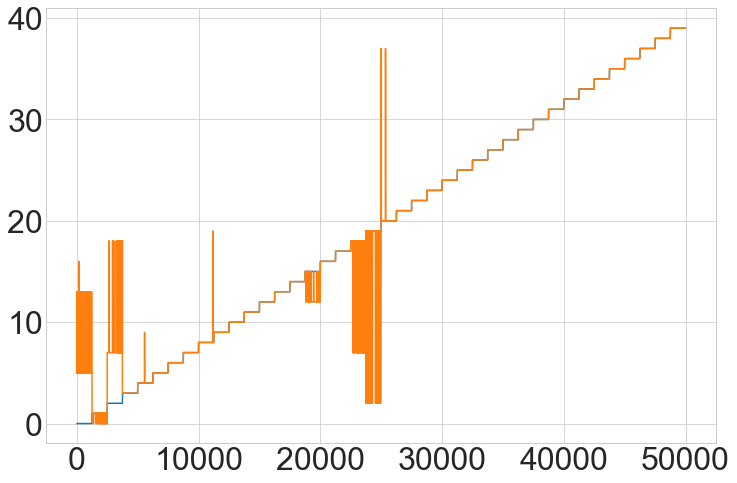

In [66]:
clf_id = 0
predicts = models[clf_id][0].predict(X_test)
plt.plot(y_test)
plt.plot(predicts)
print(f"Accuracy of {models[clf_id][1]}:\t {models[clf_id][0].score(X_test,y_test)}")

In [69]:
df_lda_tsfel = pd.DataFrame(predicts)
df_lda_tsfel.to_csv('LDA_TSFEL_FULL.csv')

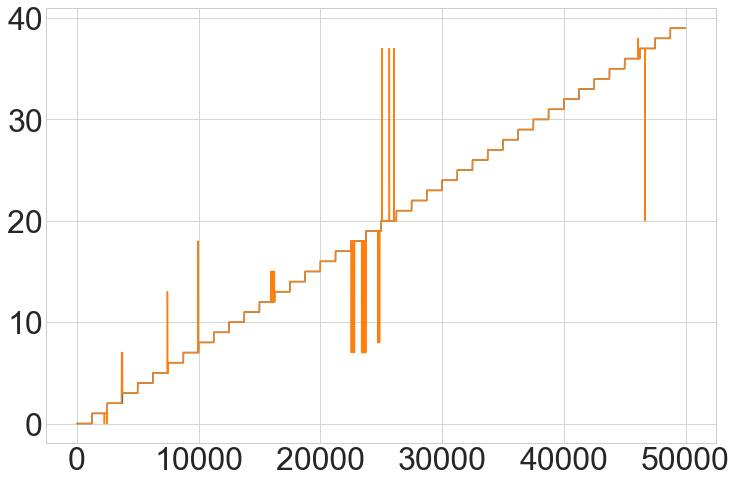

In [53]:
predicts = models[0][0].predict(X_train)
plt.plot(y_train)
plt.plot(predicts)

## CORELATION-BASED FS

In [54]:
df_all = df_train.copy()
print(df_all.shape)

if 'source' in df_all.columns:
    df_all = df_all.drop(columns='source')

# Create correlation matrix
corr_matrix = df_all.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
# Drop features 
df_train.drop(to_drop, axis=1, inplace=True)
df_test.drop(to_drop, axis=1, inplace=True)
print(df_train.shape, df_test.shape,)

(50000, 390)


c:\users\ronkin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


(50000, 248) (50000, 248)


In [55]:
X_train_ = df_train.astype('float32').values
X_test_ = df_test.astype('float32').values
scaler = MinMaxScaler()
X_train_ = scaler.fit_transform(X_train_)
X_test_  = scaler.transform(X_test_)

In [56]:
from copy import deepcopy
models_ = deepcopy(models)

for model,name in models_:
    print(name)
    model.fit(X_train_,y_train)
    print(f"Accuracy for test: {name}:\t {model.score(X_test_,y_test)},Accuracy for train: {model.score(X_train_,y_train)}")

Linear Discriminant Analysis
Accuracy for test: Linear Discriminant Analysis:	 0.90642,Accuracy for train: 0.99602
Random Forest Classifier
Accuracy for test: Random Forest Classifier:	 0.804,Accuracy for train: 1.0
Logistic Regression


c:\users\ronkin\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Accuracy for test: Logistic Regression:	 0.59752,Accuracy for train: 0.9721
Naive Bayes Classifier
Accuracy for test: Naive Bayes Classifier:	 0.83124,Accuracy for train: 0.99298


## CORRELATION + RANDOM FOREST BASED FEATURE SELECTION

In [58]:
featuresrf = models_[1][0].feature_importances_
print(featuresrf.shape)

(248,)


In [60]:
featuresrf = models_[1][0].feature_importances_
print(featuresrf.shape)
idx4rest = np.where(featuresrf>0.2*featuresrf.max())#0.023=0.32
# print(df_train.columns[:-1][idx4rest])
X_train__ = X_train_[:,idx4rest[0]]
X_test__  = X_test_ [:,idx4rest[0]]
print(X_train__.shape)

(248,)
(50000, 26)


In [61]:
models__ = deepcopy(models)

for model,name in models__:
    print(name)
    model.fit(X_train__,y_train)
    print(f"Accuracy for test: {name}:\t {model.score(X_test__,y_test)},Accuracy for train: {model.score(X_train__,y_train)}")

Linear Discriminant Analysis
Accuracy for test: Linear Discriminant Analysis:	 0.90824,Accuracy for train: 0.9867
Random Forest Classifier
Accuracy for test: Random Forest Classifier:	 0.8589,Accuracy for train: 1.0
Logistic Regression


c:\users\ronkin\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Accuracy for test: Logistic Regression:	 0.65192,Accuracy for train: 0.9634
Naive Bayes Classifier
Accuracy for test: Naive Bayes Classifier:	 0.8481,Accuracy for train: 0.99424


## RANDOM FOREST BASED FEATURE SELECTION

In [62]:
featuresrf = models[1][0].feature_importances_
print(featuresrf.shape)
idx4rest = np.where(featuresrf>0.2*featuresrf.max())#0.023=0.32
# print(df_train.columns[:-1][idx4rest])
X_train__ = X_train[:,idx4rest[0]]
X_test__  = X_test[:,idx4rest[0]]
print(X_train__.shape)

(390,)
(50000, 23)


In [63]:
models__ = deepcopy(models)

for model,name in models__:
    print(name)
    model.fit(X_train__,y_train)
    print(f"Accuracy for test: {name}:\t {model.score(X_test__,y_test)},Accuracy for train: {model.score(X_train__,y_train)}")

Linear Discriminant Analysis
Accuracy for test: Linear Discriminant Analysis:	 0.86386,Accuracy for train: 0.98656
Random Forest Classifier
Accuracy for test: Random Forest Classifier:	 0.92882,Accuracy for train: 1.0
Logistic Regression


c:\users\ronkin\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Accuracy for test: Logistic Regression:	 0.71584,Accuracy for train: 0.95226
Naive Bayes Classifier
Accuracy for test: Naive Bayes Classifier:	 0.91126,Accuracy for train: 0.9932


Accuracy of Random Forest Classifier:	 0.92882


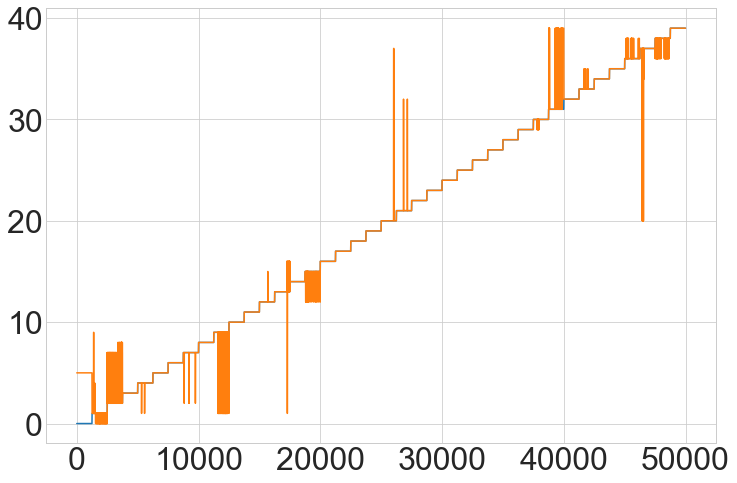

In [70]:
clf_id = 1
predicts = models__[clf_id][0].predict(X_test__)
plt.plot(y_test)
plt.plot(predicts)
print(f"Accuracy of {models[clf_id][1]}:\t {models__[clf_id][0].score(X_test__,y_test)}")

In [71]:
df_tsfel_rf = pd.DataFrame(predicts)
df_tsfel_rf.to_csv('tsfel_rf_fs.csv')

## ANOVA

In [65]:
from sklearn.feature_selection import SelectKBest, RFECV,RFE, VarianceThreshold, SelectFromModel
from sklearn.feature_selection import f_classif,  chi2,  mutual_info_classif 

# Create an SelectKBest object to select features with two best ANOVA F-Values
fselector = SelectKBest(chi2, k=10)
fselector = SelectKBest(f_classif, k=X_train.shape[0]*0.2)
# fselector = SelectKBest(mutual_info_classif, k=18)
# fselector = VarianceThreshold(threshold=.034)
# fselector = RFECV(estimator=models[0][0], step=1, scoring='neg_mean_squared_error')
# fselector = RFE(estimator=models[0][0], step=1)
# fselector = SelectFromModel(estimator=models[0][0],norm_order=1)

# Apply the SelectKBest object to the features and target
fselector.fit(X_train, y_train)


ValueError: k should be >=0, <= n_features = 390; got 10000.0. Use k='all' to return all features.

In [ ]:
X_train_1 = fselector.transform(X_train)
X_test_1  = fselector.transform(X_test)
X_train_1.shape

In [ ]:
models_1 = deepcopy(models)

for model,name in models_1:
    print(name)
    model.fit(X_train_1,y_train)
    print(f"Accuracy for test: {name}:\t {model.score(X_test_1,y_test)},Accuracy for train: {model.score(X_train_1,y_train)}")